In [11]:
import tensorflow as tf
import keras
from keras.layers import AveragePooling2D,SeparableConv2D,ReLU,Input,BatchNormalization,GlobalAveragePooling2D, GlobalMaxPooling2D, Reshape, Dense, Multiply, Permute, Concatenate, Conv2D, Add, Activation, Lambda, Softmax
from keras.activations import sigmoid,softmax
from keras.models import Sequential
# import visualkeras
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import shutil
from PIL import Image
import random
from glob import glob
from sklearn.utils import shuffle
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping, ReduceLROnPlateau,CSVLogger
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from keras import regularizers
from tensorflow.keras.preprocessing.image import load_img, img_to_array

-----------------------------------------------------------------------------------

			Images after extracting faces



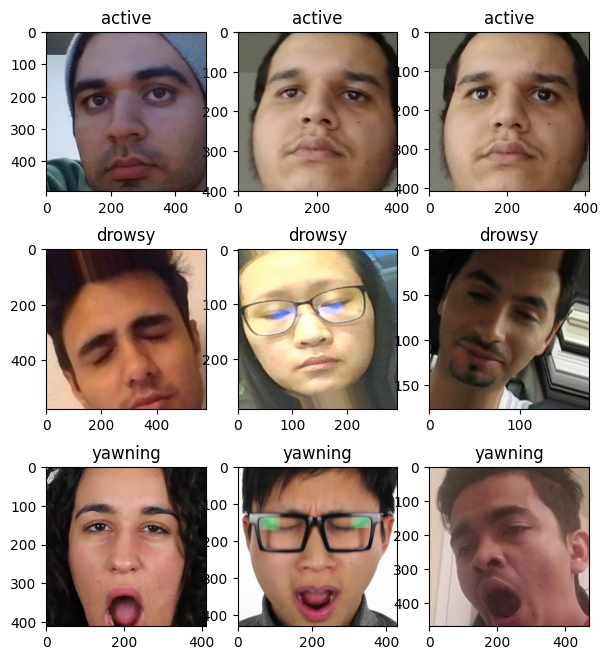

In [12]:
""" Visualization of images Before and after face extraction """

def display_images_from_classes(class_directories,class_names, num_images_to_display, num_rows, num_cols):
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(7, 8))

    for class_index, class_directory in enumerate(class_directories):
        image_files = [f for f in os.listdir(class_directory) if f.endswith(('.jpg', '.jpeg', '.png'))]

        for i in range(num_images_to_display):
            if i < len(image_files):
                image_file = image_files[i]
                image_path = os.path.join(class_directory, image_file)
                image = Image.open(image_path)

                ax = axes[class_index, i]

                ax.imshow(image)
                ax.set_title(f'{class_names[class_index]}')

        for i in range(num_images_to_display, num_cols):
            ax = axes[class_index, i]
            ax.axis('off')

    for class_index in range(len(class_directories)):
        for i in range(num_images_to_display, num_cols):
            ax = axes[class_index, i]
            ax.axis('off')
    plt.savefig("comb_data.jpg")

    plt.show()



print("-----------------------------------------------------------------------------------\n")
print("\t\t\tImages after extracting faces\n")
a1 = "/kaggle/input/final-aug-ddd/Final_DDD/trvalte/test/active"
a3 = "/kaggle/input/final-aug-ddd/Final_DDD/trvalte/test/yawning"
a2 = "/kaggle/input/final-aug-ddd/Final_DDD/trvalte/test/drowsy"
# Specify the directories for the three classes
a_class_directories = [a1,a2,a3]
a_class_names = ['active','drowsy','yawning']
num_images_to_display = 3
num_rows = len(a_class_directories)  # One row for each class
num_cols = num_images_to_display
display_images_from_classes(a_class_directories, a_class_names,num_images_to_display, num_rows, num_cols)


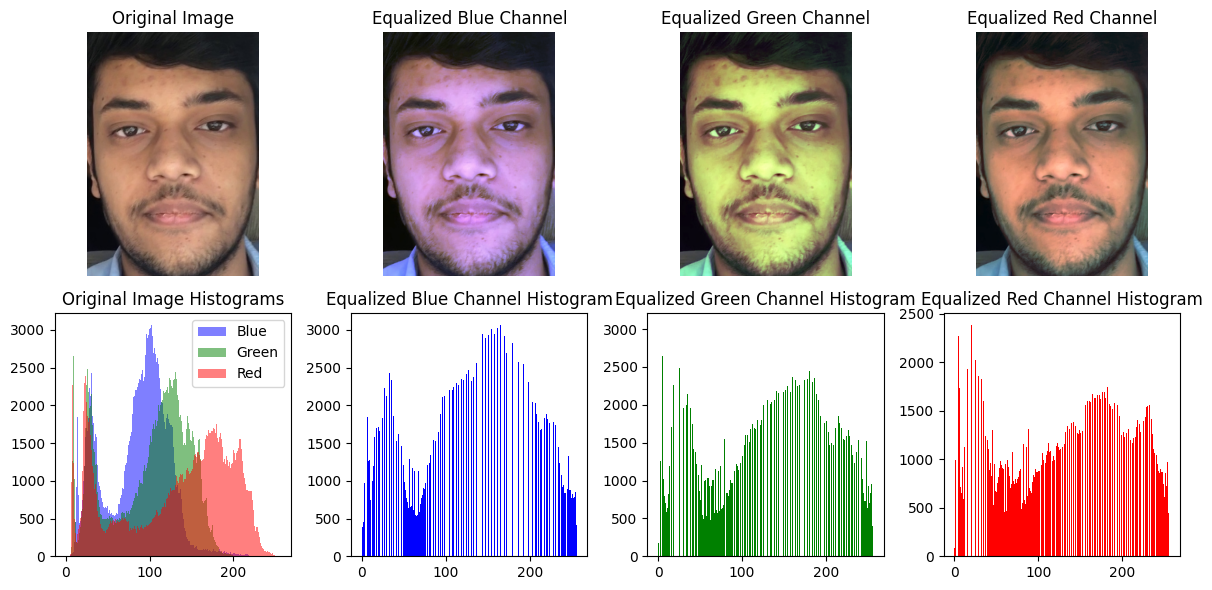

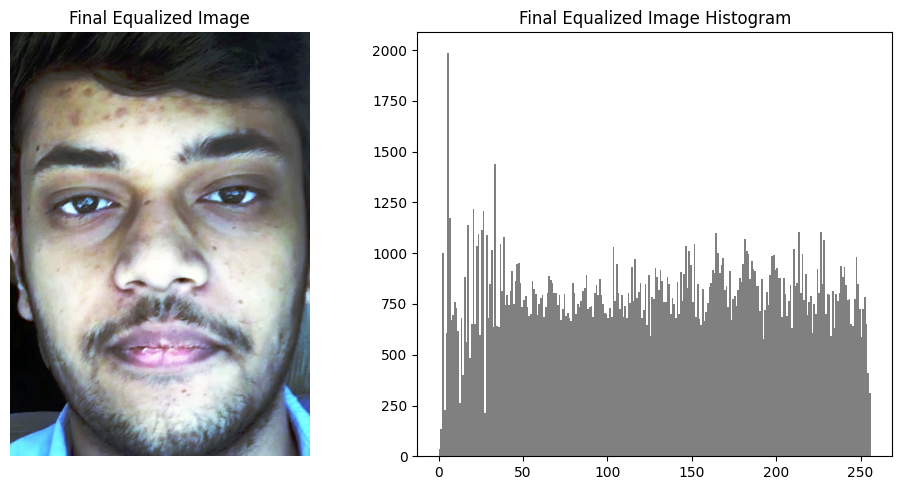

In [13]:
import cv2
import matplotlib.pyplot as plt

# Load the color image
image_path = '/kaggle/input/final-aug-ddd/Final_DDD/prepro_data/active/10_face.jpg'
image = cv2.imread(image_path)

# Split the image into its color channels
b, g, r = cv2.split(image)

# Equalize histograms for each color channel
equalized_b = cv2.equalizeHist(b)
equalized_g = cv2.equalizeHist(g)
equalized_r = cv2.equalizeHist(r)

# Merge the equalized color channels
equalized_image = cv2.merge((equalized_b, equalized_g, equalized_r))

# Plotting original and equalized images
plt.figure(figsize=(12, 6))

# Plotting original image and histograms
plt.subplot(2, 4, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

plt.subplot(2, 4, 5)
plt.hist(b.flatten(), 256, [0, 256], color='b', alpha=0.5)
plt.hist(g.flatten(), 256, [0, 256], color='g', alpha=0.5)
plt.hist(r.flatten(), 256, [0, 256], color='r', alpha=0.5)
plt.title('Original Image Histograms')
plt.legend(['Blue', 'Green', 'Red'])

# Plotting equalized color channels and histograms
plt.subplot(2, 4, 2)
plt.imshow(cv2.cvtColor(cv2.merge((equalized_b, g, r)), cv2.COLOR_BGR2RGB))
plt.title('Equalized Blue Channel')
plt.axis('off')

plt.subplot(2, 4, 6)
plt.hist(equalized_b.flatten(), 256, [0, 256], color='b')
plt.title('Equalized Blue Channel Histogram')

plt.subplot(2, 4, 3)
plt.imshow(cv2.cvtColor(cv2.merge((b, equalized_g, r)), cv2.COLOR_BGR2RGB))
plt.title('Equalized Green Channel')
plt.axis('off')

plt.subplot(2, 4, 7)
plt.hist(equalized_g.flatten(), 256, [0, 256], color='g')
plt.title('Equalized Green Channel Histogram')

plt.subplot(2, 4, 4)
plt.imshow(cv2.cvtColor(cv2.merge((b, g, equalized_r)), cv2.COLOR_BGR2RGB))
plt.title('Equalized Red Channel')
plt.axis('off')

plt.subplot(2, 4, 8)
plt.hist(equalized_r.flatten(), 256, [0, 256], color='r')
plt.title('Equalized Red Channel Histogram')

# Display the plots
plt.tight_layout()
output_file = 'channel_wise_equalized_image_histogram.jpg'
plt.savefig(output_file, bbox_inches='tight', pad_inches=0.1)
plt.show()

# Plotting final merged equalized image and its histogram
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(equalized_image, cv2.COLOR_BGR2RGB))
plt.title('Final Equalized Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.hist(cv2.cvtColor(equalized_image, cv2.COLOR_BGR2GRAY).flatten(), 256, [0, 256], color='gray')
plt.title('Final Equalized Image Histogram')

plt.tight_layout()
output_file = 'final_equalized_image_histogram.jpg'
plt.savefig(output_file, bbox_inches='tight', pad_inches=0.1)
plt.show()


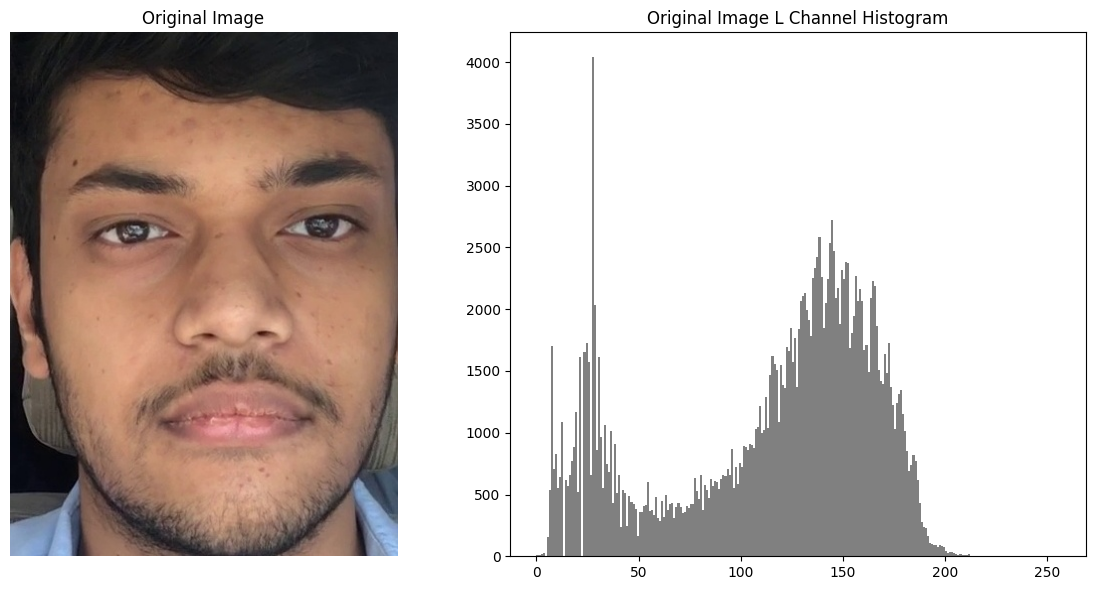

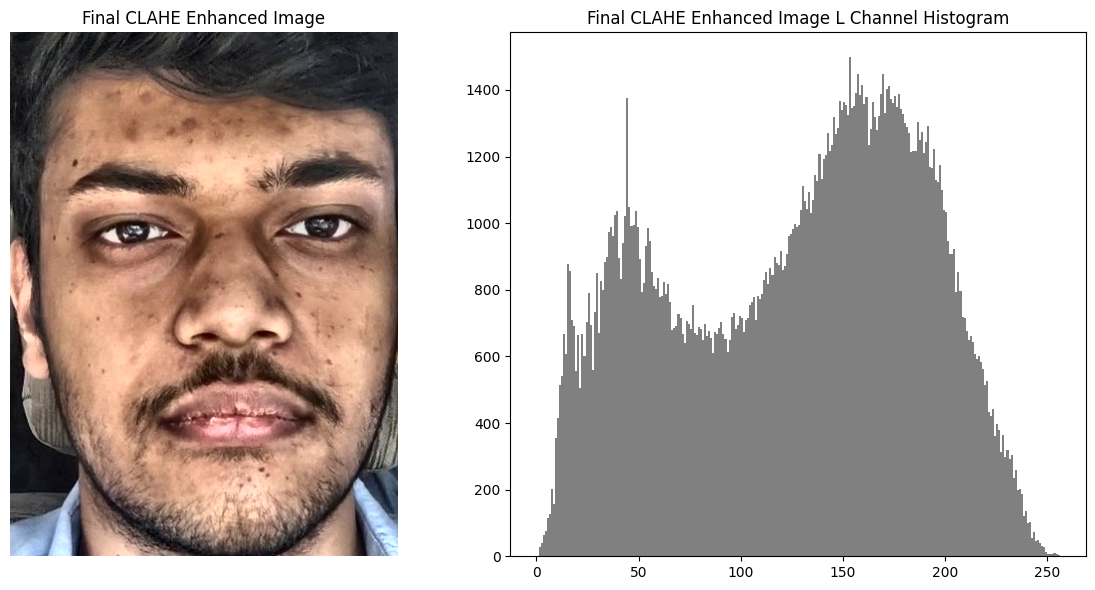

In [14]:
import cv2
import matplotlib.pyplot as plt

# Load the color image
image_path = '/kaggle/input/final-aug-ddd/Final_DDD/prepro_data/active/112_face.jpg'
image = cv2.imread(image_path)

# Convert the image to LAB color space
lab_image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)

# Split the LAB image into its channels
l, a, b = cv2.split(lab_image)

# Create a CLAHE object (Contrast Limited Adaptive Histogram Equalization)
clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))

# Apply CLAHE to the L channel
clahe_l = clahe.apply(l)

# Merge the CLAHE enhanced L channel with the original A and B channels
clahe_image = cv2.merge((clahe_l, a, b))

# Convert the image back to BGR color space
final_image = cv2.cvtColor(clahe_image, cv2.COLOR_LAB2BGR)

# Plotting original and equalized images
plt.figure(figsize=(12, 6))

# Plotting original image and histograms
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.hist(l.flatten(), 256, [0, 256], color='gray')
plt.title('Original Image L Channel Histogram')

# Display the plots
plt.tight_layout()
plt.show()

# Plotting final CLAHE enhanced image and its histogram
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(final_image, cv2.COLOR_BGR2RGB))
plt.title('Final CLAHE Enhanced Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.hist(clahe_l.flatten(), 256, [0, 256], color='gray')
plt.title('Final CLAHE Enhanced Image L Channel Histogram')

plt.tight_layout()
plt.show()


In [15]:
# def channel_wise_histogram_equalization(image):
#     # Split the image into its color channels
#     b, g, r = cv2.split(image)

#     # Apply histogram equalization to each color channel
#     equalized_b = cv2.equalizeHist(b)
#     equalized_g = cv2.equalizeHist(g)
#     equalized_r = cv2.equalizeHist(r)

#     # Merge the equalized color channels
#     equalized_image = cv2.merge((equalized_b, equalized_g, equalized_r))

#     return equalized_image

In [16]:
import cv2

def channel_wise_clahe(image, clip_limit=2.0, grid_size=(8, 8)):
    # Split the image into its color channels
    b, g, r = cv2.split(image)

    # Create a CLAHE object
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=grid_size)

    # Apply CLAHE to each color channel
    clahe_b = clahe.apply(b)
    clahe_g = clahe.apply(g)
    clahe_r = clahe.apply(r)

    # Merge the CLAHE enhanced color channels
    clahe_image = cv2.merge((clahe_b, clahe_g, clahe_r))

    return clahe_image


In [17]:
#testing
active_images_path = '/kaggle/input/final-aug-ddd/Final_DDD/trvalte/train/active'
drowsy_images_path = '/kaggle/input/final-aug-ddd/Final_DDD/trvalte/train/drowsy'
yawning_images_path = '/kaggle/input/final-aug-ddd/Final_DDD/trvalte/train/yawning'
images = []
labels = []

# Load real images
for filename in os.listdir(active_images_path):
    if filename.endswith(".jpg"):
        img = cv2.imread(os.path.join(active_images_path, filename))
        img = channel_wise_clahe(img)
        img = cv2.resize(img,(224,224))
        img = img.reshape(224,224,3)
        img = img_to_array(img)
        images.append(img)
        labels.append(0)

# Load fake images
for filename in os.listdir(drowsy_images_path):
    if filename.endswith(".jpg"):
        img = cv2.imread(os.path.join(drowsy_images_path, filename))
        img = channel_wise_clahe(img)
        img = cv2.resize(img,(224,224))
        img = img.reshape(224,224,3)
        img = img_to_array(img)
        images.append(img)
        labels.append(1)

for filename in os.listdir(yawning_images_path):
    if filename.endswith(".jpg"):
        img = cv2.imread(os.path.join(yawning_images_path, filename))
        img = channel_wise_clahe(img)
        img = cv2.resize(img,(224,224))
        img = img.reshape(224,224,3)
        img = img_to_array(img)
        images.append(img)
        labels.append(2)

train_images = np.array(images)
train_labels = np.array(labels)

temp = list(zip(train_images, train_labels))
random.shuffle(temp)
res1, res2 = zip(*temp)
res1, res2 = list(res1), list(res2)

X_train = np.array(res1) / 255.0
y_train= np.array(res2)
y_train = tf.keras.utils.to_categorical(y_train, num_classes=3)

# del train_images
# del train_labels

In [18]:
X_train.shape,y_train.shape

((3279, 224, 224, 3), (3279, 3))

In [19]:
#testing
active_images_path = '/kaggle/input/final-aug-ddd/Final_DDD/trvalte/validation/active'
drowsy_images_path = '/kaggle/input/final-aug-ddd/Final_DDD/trvalte/validation/drowsy'
yawning_images_path = '/kaggle/input/final-aug-ddd/Final_DDD/trvalte/validation/yawning'
images = []
labels = []

# Load real images
for filename in os.listdir(active_images_path):
    if filename.endswith(".jpg"):
        img = cv2.imread(os.path.join(active_images_path, filename))
        img = channel_wise_clahe(img)
        img = cv2.resize(img,(224,224))
        img = img.reshape(224,224,3)
        img = img_to_array(img)
        images.append(img)
        labels.append(0)

# Load fake images
for filename in os.listdir(drowsy_images_path):
    if filename.endswith(".jpg"):
        img = cv2.imread(os.path.join(drowsy_images_path, filename))
        img = channel_wise_clahe(img)
        img = cv2.resize(img,(224,224))
        img = img.reshape(224,224,3)
        img = img_to_array(img)
        images.append(img)
        labels.append(1)

for filename in os.listdir(yawning_images_path):
    if filename.endswith(".jpg"):
        img = cv2.imread(os.path.join(yawning_images_path, filename))
        img = channel_wise_clahe(img)
        img = cv2.resize(img,(224,224))
        img = img.reshape(224,224,3)
        img = img_to_array(img)
        images.append(img)
        labels.append(2)

val_images = np.array(images)
val_labels = np.array(labels)

X_val= np.array(val_images)/255.0
y_val= val_labels
y_val_wle=val_labels
y_val = tf.keras.utils.to_categorical(y_val, num_classes=3)

# test_images=[]
# test_labels=[]

In [20]:
#testing
active_images_path = '/kaggle/input/final-aug-ddd/Final_DDD/trvalte/test/active'
drowsy_images_path = '/kaggle/input/final-aug-ddd/Final_DDD/trvalte/test/drowsy'
yawning_images_path = '/kaggle/input/final-aug-ddd/Final_DDD/trvalte/test/yawning'
images = []
labels = []


for filename in os.listdir(active_images_path):
    if filename.endswith(".jpg"):
        img = cv2.imread(os.path.join(active_images_path, filename))
        img = channel_wise_clahe(img)
        img = cv2.resize(img,(224,224))
        img = img.reshape(224,224,3)
        img = img_to_array(img)
        images.append(img)
        labels.append(0)


for filename in os.listdir(drowsy_images_path):
    if filename.endswith(".jpg"):
        img = cv2.imread(os.path.join(drowsy_images_path, filename))
        img = channel_wise_clahe(img)
        img = cv2.resize(img,(224,224))
        img = img.reshape(224,224,3)
        img = img_to_array(img)
        images.append(img)
        labels.append(1)

for filename in os.listdir(yawning_images_path):
    if filename.endswith(".jpg"):
        img = cv2.imread(os.path.join(yawning_images_path, filename))
        img = channel_wise_clahe(img)
        img = cv2.resize(img,(224,224))
        img = img.reshape(224,224,3)
        img = img_to_array(img)
        images.append(img)
        labels.append(2)

test_images = np.array(images)
test_labels = np.array(labels)

X_test= np.array(test_images)/255.0
y_test= test_labels
y_test_wle = test_labels
y_test = tf.keras.utils.to_categorical(y_test, num_classes=3)

# test_images=[]
# test_labels=[]

In [21]:
X_test.shape,y_test.shape

((706, 224, 224, 3), (706, 3))

In [22]:
# train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(

#     rescale=1.0/255.0,  # Normalize pixel values to [0, 1]
#     rotation_range=15,  # Rotate images by up to 15 degrees
#     width_shift_range=0.15,  # Shift width by up to 15% of the image width
#     height_shift_range=0.15,  # Shift height by up to 15% of the image height
#     shear_range=0.15,  # Apply shear transformations with a max of 15%
#     zoom_range=0.15,  # Zoom in/out by up to 15%
#     horizontal_flip=True,  # Apply horizontal flips
#     fill_mode='nearest',  # Fill empty areas with the nearest pixel
#     brightness_range=[0.8, 1.2],  # Adjust brightness within this range
#     channel_shift_range=10,  # Randomly shift color channels
# )

# train_generator = train_datagen.flow_from_directory(
#     "/content/drive/MyDrive/tvt/train",
#     target_size=(224, 224),
#     batch_size=32,
#     class_mode='categorical'
# )

# validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255.0)

# validation_generator = validation_datagen.flow_from_directory(
#     "/content/drive/MyDrive/tvt/validation",
#     target_size=(224, 224),
#     batch_size=32,
#     class_mode='categorical'
# )
# # test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255.0)
# test_generator = train_datagen.flow_from_directory(
#     "/content/drive/MyDrive/tvt/test",
#     target_size=(224, 224),
#     batch_size=32,
#     class_mode='categorical'
# )

In [23]:
model=[]

In [25]:
#march = cv2.imread('/kaggle/input/model-arch/Final_lwcnn_diagram.jpg')
#arch = cv2.cvtColor(march,cv2.COLOR_BGR2RGB)
#plt.figure(figsize=(12, 6))
#plt.imshow(arch)

In [26]:
def adaptive_connection_v1(x, filters):
    x = Conv2D(filters, (3, 3),activation='relu', padding='same')(x)
    x = AveragePooling2D()(x)
    x = Conv2D(filters, (1, 1),activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    return x

def adaptive_connection_v2(x, filters):
    x = Conv2D(filters, (3, 3),activation='relu', padding='same')(x)
    x = Conv2D(filters, (1, 1),activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    return x

In [27]:
def channel_attention_module(x, ratio=8):
    batch, _, _, channel = x.shape

    ## Shared layers
    l1 = Dense(channel//ratio, activation="relu", use_bias=False)
    l2 = Dense(channel, use_bias=False)

    ## Global Average Pooling
    x1 = GlobalAveragePooling2D()(x)
    x1 = l1(x1)
    x1 = l2(x1)

    ## Global Max Pooling
    x2 = GlobalMaxPooling2D()(x)
    x2 = l1(x2)
    x2 = l2(x2)

    ## Add both the features and pass through sigmoid
    feats = x1 + x2
    feats = Activation("sigmoid")(feats)
    feats = Multiply()([x, feats])

    return feats

def spatial_attention_module(x):
    ## Average Pooling
    x1 = tf.reduce_mean(x, axis=-1)
    x1 = tf.expand_dims(x1, axis=-1)

    ## Max Pooling
    x2 = tf.reduce_max(x, axis=-1)
    x2 = tf.expand_dims(x2, axis=-1)

    ## Concatenat both the features
    feats = Concatenate()([x1, x2])
    ## Conv layer
    feats = Conv2D(1, kernel_size=7, padding="same", activation="sigmoid")(feats)
    feats = Multiply()([x, feats])

    return feats

def cbam(x):
    x = channel_attention_module(x,ratio = 8)
    x = spatial_attention_module(x)
    return x


In [28]:
# input_shape = (224,224,3)

def feature_extractor(input_shape=(224,224,3)):
    ip = Input(shape=input_shape)
    "CB1"

    # mod = Sequential()
    mod = Conv2D(16,(7,7),padding='same')(ip)
    mod = BatchNormalization()(mod)
    mod = ReLU()(mod)
    mod = Conv2D(16,(7,7),padding='same')(mod)
    mod = BatchNormalization()(mod)
    mod = ReLU()(mod)
    mod = AveragePooling2D()(mod)
    mod_copy = mod
    # print(mod_copy.shape)

    "CB2"
    mod = Conv2D(32,(5,5),padding='same')(mod)
    mod = BatchNormalization()(mod)
    mod = ReLU()(mod)
    mod = SeparableConv2D(32,(5,5),padding='same')(mod)
    mod = BatchNormalization()(mod)
    mod = ReLU()(mod)
    mod = AveragePooling2D()(mod)

    "Add1"

    ac1 = adaptive_connection_v1(mod_copy,32)
    mod = Add()([mod,ac1])
    add1 = mod
    # print(add1.shape)

    "CB3"
    mod = Conv2D(64,(3,3),padding='same')(mod)
    mod = BatchNormalization()(mod)
    mod = ReLU()(mod)
    mod = Conv2D(64,(3,3),padding='same')(mod)
    mod = BatchNormalization()(mod)
    mod = ReLU()(mod)
    mod = AveragePooling2D()(mod)

    "Add2"
    ac2 = adaptive_connection_v1(add1,64)
    mod = Add()([mod,ac2])
    add2 = mod

    "CB4"
    mod = Conv2D(128,(3,3),padding='same')(mod)
    mod = BatchNormalization()(mod)
    mod = ReLU()(mod)
    mod = SeparableConv2D(128,(3,3),padding='same')(mod)
    mod = BatchNormalization()(mod)
    mod = ReLU()(mod)
    mod = AveragePooling2D()(mod)

    "Add3"
    ac3 = adaptive_connection_v1(add2,128)
    mod = Add()([mod,ac3])
    add3 = mod
    # print(add3.shape)

    "CBAM"

    mod = cbam(mod)


    mod = SeparableConv2D(256,(3,3),padding='same')(mod)
    mod = BatchNormalization()(mod)
    mod = ReLU()(mod)
    mod = SeparableConv2D(3,(3,3),padding='same')(mod)
    mod = BatchNormalization()(mod)
    mod = ReLU()(mod)
    # print(mod.shape)

    "Add4"
    ac4 = adaptive_connection_v2(add3,3)
    mod = Add()([mod,ac4])
    # print(mod.shape)
    fe = tf.keras.models.Model(inputs = ip,outputs = mod)
    return fe

"Classifier"
def classifier_module(mod):
    mod = GlobalAveragePooling2D()(mod)
    mod = Softmax()(mod)
    return mod

def create_model(input_shape=(224, 224, 3)):
    feature_extractor_model = feature_extractor(input_shape)
    classifier_output = classifier_module(feature_extractor_model.output)

    model = tf.keras.Model(inputs=feature_extractor_model.input, outputs=classifier_output)
    return model

model = create_model()
model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()




Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 224, 224, 16)         2368      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 224, 224, 16)         64        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 re_lu (ReLU)                (None, 224, 224, 16)         0         ['batch_normalization[0]

In [29]:
callbacks = [
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6, verbose=1),
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ]

# y_train = tf.keras.utils.to_categorical(y_train, num_classes=3)
# y_test = tf.keras.utils.to_categorical(y_test, num_classes=3)
history = model.fit(
        X_train,y_train, validation_data=(X_val,y_val),
        epochs=80,
        callbacks=callbacks
    )



Epoch 1/80
103/103 [==============================] - 33s 144ms/step - loss: 0.7733 - accuracy: 0.6703 - val_loss: 1.2265 - val_accuracy: 0.3390 - lr: 0.0010
Epoch 2/80
103/103 [==============================] - 11s 104ms/step - loss: 0.4659 - accuracy: 0.8579 - val_loss: 1.5565 - val_accuracy: 0.3390 - lr: 0.0010
Epoch 3/80
103/103 [==============================] - 11s 104ms/step - loss: 0.3340 - accuracy: 0.9210 - val_loss: 1.8745 - val_accuracy: 0.5427 - lr: 0.0010
Epoch 4/80
103/103 [==============================] - 11s 104ms/step - loss: 0.2369 - accuracy: 0.9515 - val_loss: 1.3605 - val_accuracy: 0.8519 - lr: 0.0010
Epoch 5/80
103/103 [==============================] - 11s 104ms/step - loss: 0.1799 - accuracy: 0.9652 - val_loss: 1.9096 - val_accuracy: 0.7137 - lr: 0.0010
Epoch 6/80
103/103 [==============================] - ETA: 0s - loss: 0.1354 - accuracy: 0.9771
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
103/103 [============================

In [39]:
"""Training loss and accuray values after each epoch"""
# epochs = hp["num_epochs"]
epochs = [i for i in range(1,18+1)]
loss_values = history.history['loss']
acc = history.history['accuracy']

"""Validation loss and accuray values after each epoch"""
vloss_values = history.history['val_loss']
vacc = history.history['val_accuracy']
# print(len(loss_values))
# print(len(epochs))

/tmp/ipykernel_47/1459423806.py:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, vloss_values, 'b', color='b', label='Validation loss')
/tmp/ipykernel_47/1459423806.py:16: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, vacc, 'b', color='b', label='Validation accuracy')


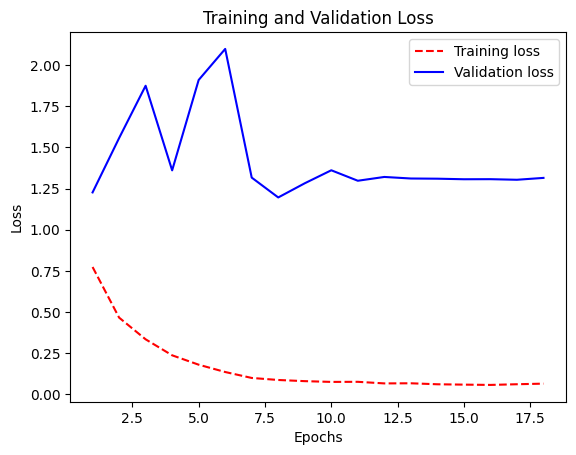

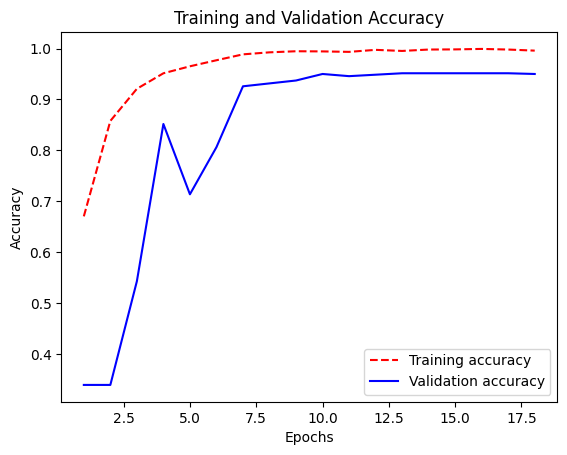

In [40]:
# Plotting values

# Plot training and validation loss
plt.figure()
plt.plot(epochs, loss_values, '--', color='r', label='Training loss')
plt.plot(epochs, vloss_values, 'b', color='b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('tvalloss1.png')  # Save the plot as a PNG file

# Plot training and validation accuracy
plt.figure()
plt.plot(epochs, acc, '--', color='r', label='Training accuracy')
plt.plot(epochs, vacc, 'b', color='b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('tvalacc1.png')  # Save the plot as a PNG file


In [32]:

model.evaluate(X_test,y_test)

23/23 [==============================] - 1s 42ms/step - loss: 0.2016 - accuracy: 0.9660


[0.20159417390823364, 0.9660056829452515]

In [41]:
im = cv2.imread("/kaggle/input/final-aug-ddd/Final_DDD/trvalte/validation/yawning/6_face.jpg")
im = channel_wise_clahe(im)
im = cv2.resize(im,(224,224))
im = im/255.0
im = im.reshape(224,224,3)
im = np.expand_dims(im,axis=0)
pred = model.predict(im)
print(np.argmax(pred))

1/1 [==============================] - 0s 275ms/step
1


23/23 [==============================] - 1s 27ms/step
[[0.9844678  0.00906863 0.00646364]
 [0.9502882  0.02488166 0.0248302 ]
 [0.971034   0.0149178  0.01404834]
 [0.9679437  0.01162687 0.02042937]
 [0.9683567  0.00715675 0.02448647]
 [0.8961573  0.01900748 0.08483516]
 [0.7474013  0.15417968 0.09841903]
 [0.9682124  0.01308282 0.01870469]
 [0.87029344 0.06804484 0.06166178]
 [0.9692068  0.01498925 0.01580391]] [0 0 0 0 0 0 0 0 0 0]


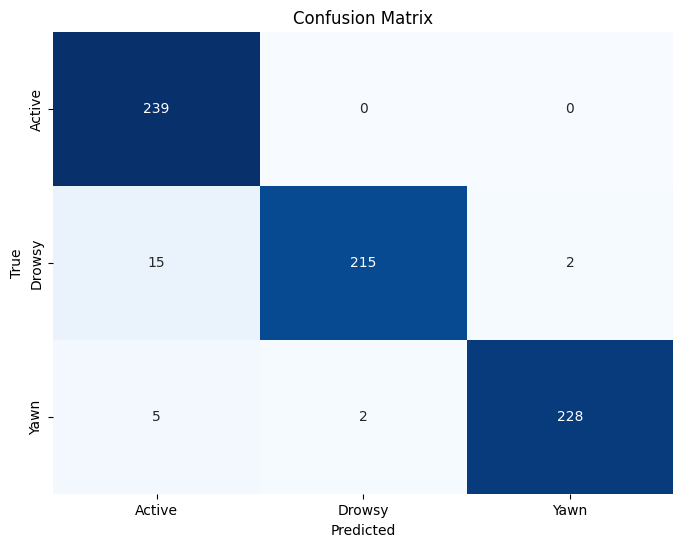

              precision    recall  f1-score   support

      Active       0.92      1.00      0.96       239
      Drowsy       0.99      0.93      0.96       232
        Yawn       0.99      0.97      0.98       235

    accuracy                           0.97       706
   macro avg       0.97      0.97      0.97       706
weighted avg       0.97      0.97      0.97       706



In [42]:
predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = y_test_wle
print(predictions[:10],true_classes[:10])
conf_mat = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=["Active", "Drowsy","Yawn"],
            yticklabels=["Active", "Drowsy","Yawn"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('cf_matrix.png')
plt.show()

target_names = ["Active", "Drowsy","Yawn"]
print(classification_report(true_classes, predicted_classes, target_names=target_names))


In [35]:
from sklearn.metrics import classification_report
cr = classification_report(true_classes, predicted_classes, target_names=["Active", "Drowsy","Yawning"])

In [36]:
print(cr)

              precision    recall  f1-score   support

      Active       0.92      1.00      0.96       239
      Drowsy       0.99      0.93      0.96       232
     Yawning       0.99      0.97      0.98       235

    accuracy                           0.97       706
   macro avg       0.97      0.97      0.97       706
weighted avg       0.97      0.97      0.97       706



In [37]:
tf.keras.models.save_model(model,'lwcnn_v6')

In [38]:
model.save('lwcnn_v7.keras')